![](https://www.researchgate.net/publication/349055345/figure/fig3/AS:987834383085568@1612529478973/FER-2013-sample-images-for-facial-emotion-recognition.jpg)

* Fer2013 dataset is a common dataset used for facial expression recognition. The dataset contains 35,887 grayscale facial images containing 7 different emotions (anger, disgust, fear, happiness, neutral, sad, and surprise).

* VGG19 is a deep learning model known as the Convolutional Neural Network (CNN) architecture. The VGG19 model has 19 layers and consists of 16 layers of convolutional layers and 3 layers of fully connected layers. Convolutional layers extract features from the input image using filters.

* Transfer learning can be performed using the pre-trained weights of the VGG19 model. Transfer learning is the use of the weights of a pre-trained model to help solve a problem in a new dataset.

* For the VGG19 model, pre-trained weights are often used to classify images in the ImageNet dataset. Therefore, the last layer of the VGG19 model is retrained to make it suitable for facial expressions in the fer2013 dataset.

* The last layer of the VGG19 model consists of fully connected layers. These layers are used to classify facial expressions in the dataset. Since there are 7 different emotion classes in the Fer2013 dataset, the last layer of the VGG19 model is retrained to have a 7-output classifier.

* Retraining of the VGG19 model is performed with multiple epochs to achieve higher accuracy rates. An epoch is a complete scan of the training data by the model once.

* During training, performance metrics such as model accuracy and loss are tracked. At the end of the training, the accuracy of the model is evaluated by its performance on the test data.
* The VGG19 model gives very good results for the classification of facial expressions in the Fer2013 dataset. However, there may be imbalance between classes in the dataset. Therefore, taking into account the imbalance of training data between classes can help improve the performance of the model.
 
* To further improve the performance of the model, data preprocessing techniques can be used. For example, the sizes of faces in the dataset can be standardized and filtering techniques can be applied to reduce noise.
 
* The VGG19 model is a widely used model in the field of facial expression recognition in the Fer2013 dataset. However, there are other models that perform better on different datasets. Therefore, different models may be preferred depending on the characteristics of the data set and the problem area.
 
* Finally, different metrics can be used to evaluate the performance of the model. For example, metrics such as accuracy, sensitivity, specificity, F1 score, and ROC curve can help evaluate model performance from different perspectives.

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fer2013/icml_face_data.csv
/kaggle/input/fer2013/example_submission.csv
/kaggle/input/fer2013/train.csv
/kaggle/input/fer2013/test.csv
/kaggle/input/fer2013/fer2013/fer2013/README
/kaggle/input/fer2013/fer2013/fer2013/fer2013.bib
/kaggle/input/fer2013/fer2013/fer2013/fer2013.csv


## Library

In [2]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv('/kaggle/input/fer2013/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

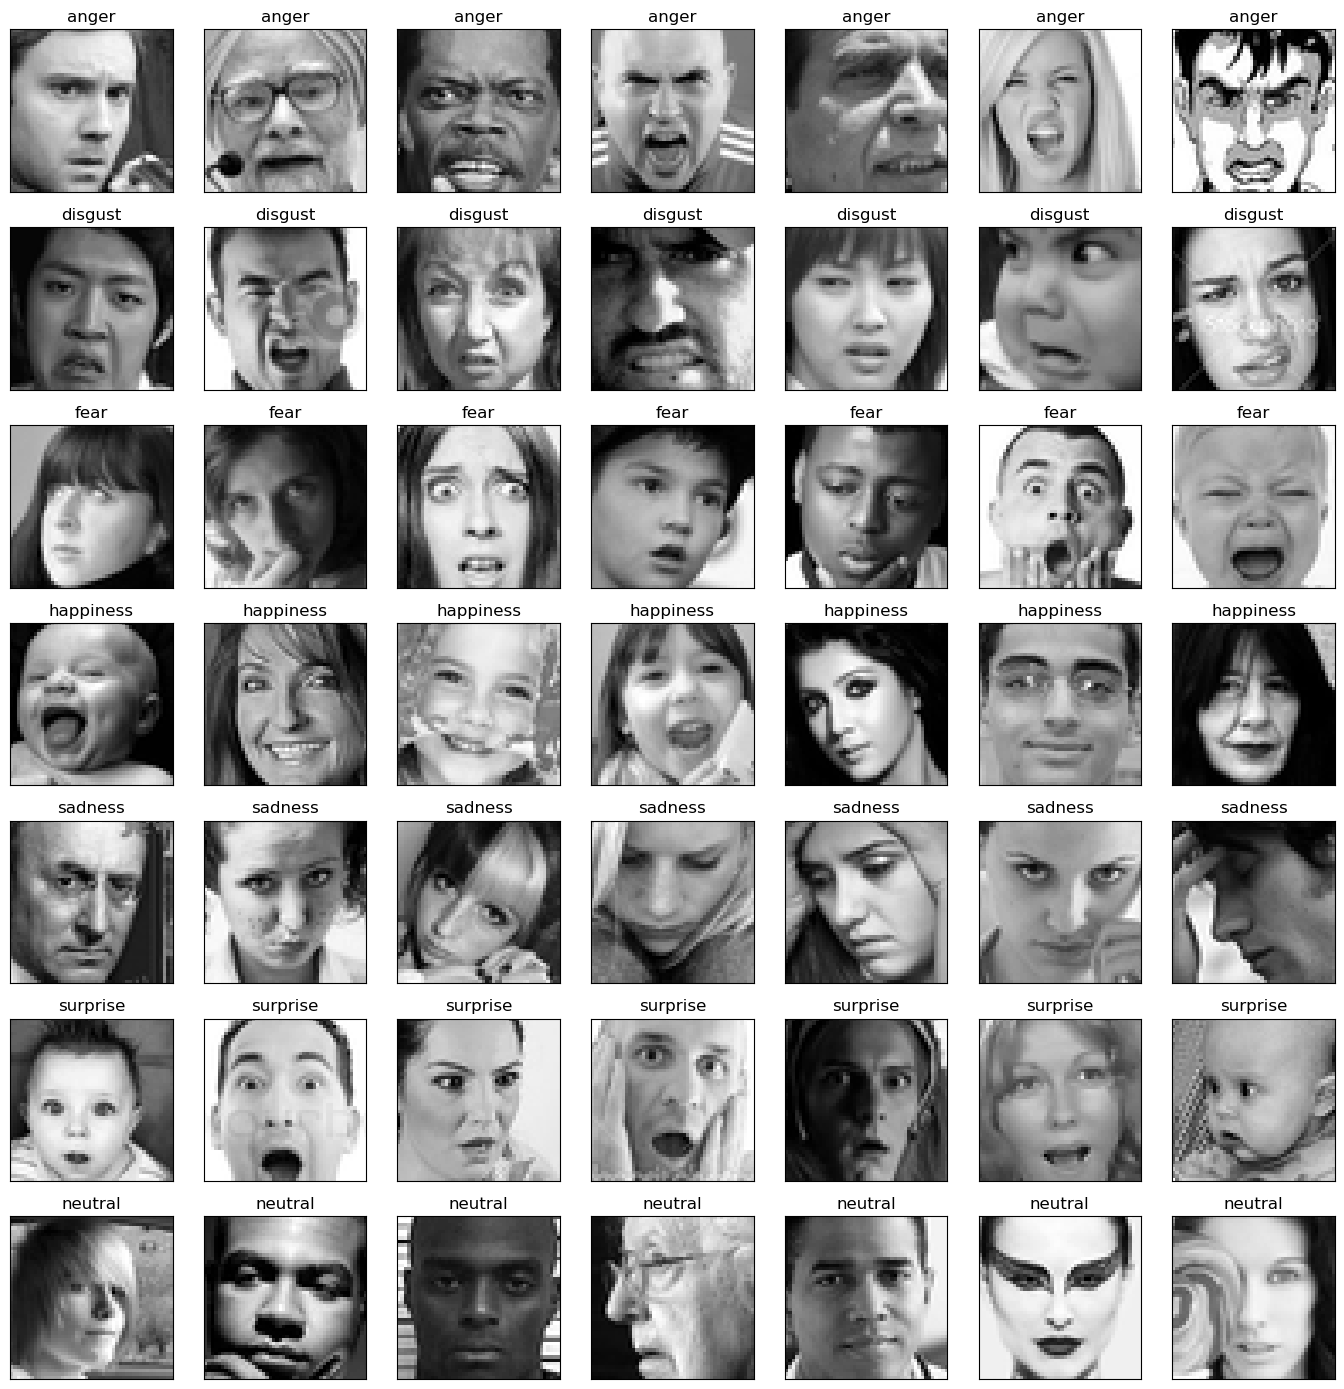

In [8]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

### Now I will make the data compatible for neural networks.

In [9]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [10]:
img_array.shape

(35887, 48, 48)

In [11]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

img_features = img_features/255

(35887, 48, 48, 3)


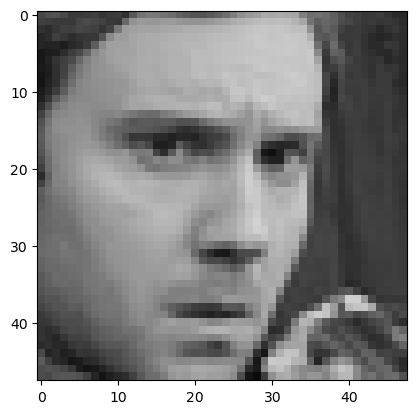

In [12]:
pyplot.imshow((img_features[0]*255).astype(np.uint8));

In [13]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Splitting the data into training and validation set.

In [15]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                      y_train_valid, 
                                                      shuffle = True, 
                                                      stratify = y_train_valid, 
                                                      test_size = 0.11, 
                                                      random_state = 42)
X_train.shape, X_valid.shape,X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((28745, 48, 48, 3),
 (3553, 48, 48, 3),
 (3589, 48, 48, 3),
 (28745, 7),
 (3553, 7),
 (3589, 7))

In [16]:
print(y_train[28744])

[0. 0. 0. 1. 0. 0. 0.]


In [17]:
# from sklearn.utils.class_weight import compute_class_weight
# int_encoded = np.argmax(y_train, axis=1)
# print(int_encoded)

# # Calculate class weights
# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(int_encoded),
#                                         y = int_encoded                                                    
#                                     )
# class_weights = dict(zip(np.unique(int_encoded), class_weights))
# class_weights

# print(class_weights)
# class_labels = np.unique(int_encoded)
# class_weights_dict = dict()
# for i in range(7):
#     class_weights_dict[i] = class_weights[i]



# sum = 0
# n_samples = []
# for i in range(7):
#     cnt = 0
#     for j in range(len(int_encoded)):
#         if int_encoded[j] ==i:
#             cnt += 1
#     print(i, cnt)
#     n_samples.append(cnt)
#     sum += cnt
        
# print("sum = ", sum )
# for i in range(7):
#     print(i, n_samples[i] * class_weights[i])

In [18]:
# X_train,X_valid, y_train, y_valid = train_test_split(img_features, 
#                                                       img_labels, 
#                                                       shuffle = True, 
#                                                       stratify = img_labels, 
#                                                       test_size = 0.1, 
#                                                       random_state = 42)


In [19]:
# del df
# del img_features
# del img_labels

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [21]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 3s 0us/step


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [22]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [23]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalMaxPooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [24]:
num_classes = 7
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [25]:
# Freeze layers up to block1_pool
for layer in model.layers:
    layer.trainable = True
# for layer in model.layers[:4]:
#     layer.trainable = False
for layer in model.layers:
    print(layer.name, layer.trainable)

input_1 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_conv4 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
global_max_pooling2d True
out_layer True


### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [26]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [27]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [28]:
def focal_loss(gamma=2):
    def loss(y_true, y_pred):
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
        pt = tf.math.exp(-ce_loss)
        focal_loss = tf.pow(1 - pt, gamma) * ce_loss
        return focal_loss
    return loss
gamma = 5

In [29]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 60
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]


model.compile(loss= focal_loss(gamma=gamma),
              optimizer = optims[0],
              metrics = ['accuracy'])


In [30]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,

                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


898/898 [==============================] - 79s 73ms/step - loss: 0.5926 - accuracy: 0.3925 - val_loss: 0.4603 - val_accuracy: 0.4818 - lr: 1.0000e-04
Epoch 2/60
898/898 [==============================] - 67s 74ms/step - loss: 0.4474 - accuracy: 0.4979 - val_loss: 0.3962 - val_accuracy: 0.5480 - lr: 1.0000e-04
Epoch 3/60
898/898 [==============================] - 64s 71ms/step - loss: 0.3983 - accuracy: 0.5288 - val_loss: 0.3682 - val_accuracy: 0.5539 - lr: 1.0000e-04
Epoch 4/60
898/898 [==============================] - 69s 77ms/step - loss: 0.3673 - accuracy: 0.5523 - val_loss: 0.3575 - val_accuracy: 0.5829 - lr: 1.0000e-04
Epoch 5/60
898/898 [==============================] - 66s 73ms/step - loss: 0.3486 - accuracy: 0.5643 - val_loss: 0.3585 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 6/60
898/898 [==============================] - 65s 72ms/step - loss: 0.3271 - accuracy: 0.5810 - val_loss: 0.3151 - val_accuracy: 0.6015 - lr: 1.0000e-04
Epoch 7/60
898/898 [=========================

In [31]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

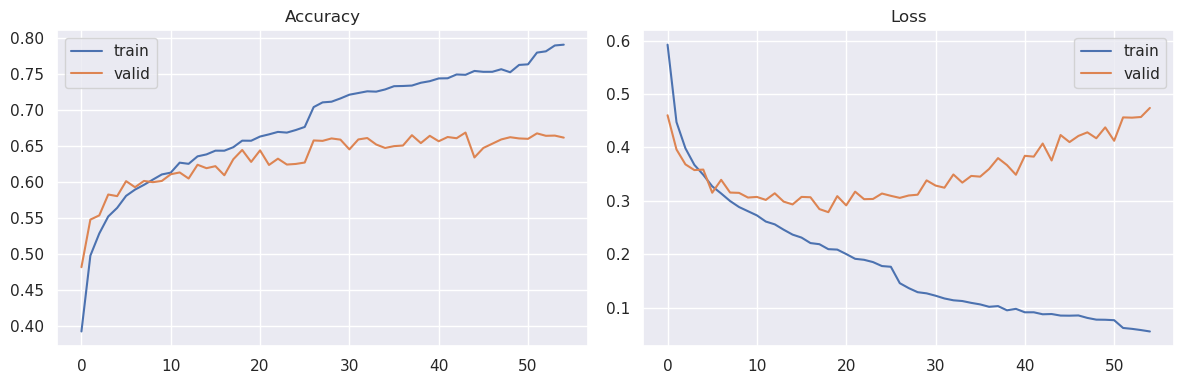

In [32]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


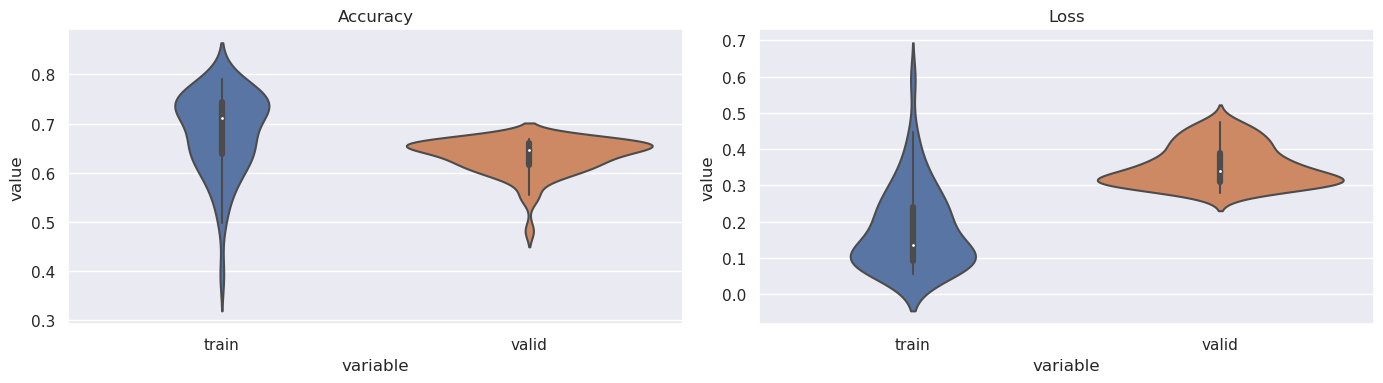

In [33]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

This is for testing data
113/113 [==============================] - 1s 9ms/step
total wrong validation predictions: 1196


              precision    recall  f1-score   support

           0     0.5631    0.6848    0.6180       495
           1     0.7750    0.5636    0.6526        55
           2     0.5383    0.3848    0.4487       512
           3     0.8827    0.8621    0.8723       899
           4     0.5571    0.5296    0.5430       608
           5     0.6980    0.7975    0.7445       400
           6     0.6138    0.6613    0.6366       620

    accuracy                         0.6668      3589
   macro avg     0.6611    0.6405    0.6451      3589
weighted avg     0.6656    0.6668    0.6627      3589



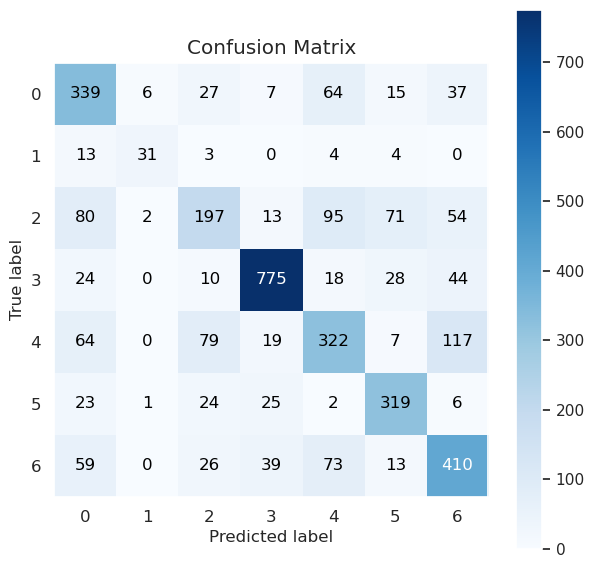

In [34]:
print("This is for testing data")
yhat_test = np.argmax(model.predict(X_test), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')
report = classification_report(np.argmax(y_test, axis=1), yhat_test, digits=4)
print(report)

this is for validationd data
112/112 [==============================] - 1s 8ms/step
total wrong validation predictions: 1176


              precision    recall  f1-score   support

           0     0.5631    0.6848    0.6180       495
           1     0.7750    0.5636    0.6526        55
           2     0.5383    0.3848    0.4487       512
           3     0.8827    0.8621    0.8723       899
           4     0.5571    0.5296    0.5430       608
           5     0.6980    0.7975    0.7445       400
           6     0.6138    0.6613    0.6366       620

    accuracy                         0.6668      3589
   macro avg     0.6611    0.6405    0.6451      3589
weighted avg     0.6656    0.6668    0.6627      3589



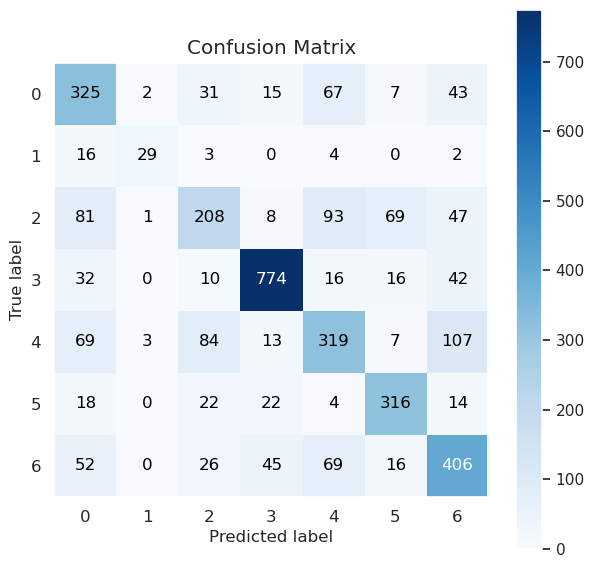

In [35]:
print("this is for validationd data")
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
report = classification_report(np.argmax(y_test, axis=1), yhat_test, digits=4)
print(report)

### The confusion matrix clearly shows that our model is doing good job on the class happy but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [36]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 17ms/step


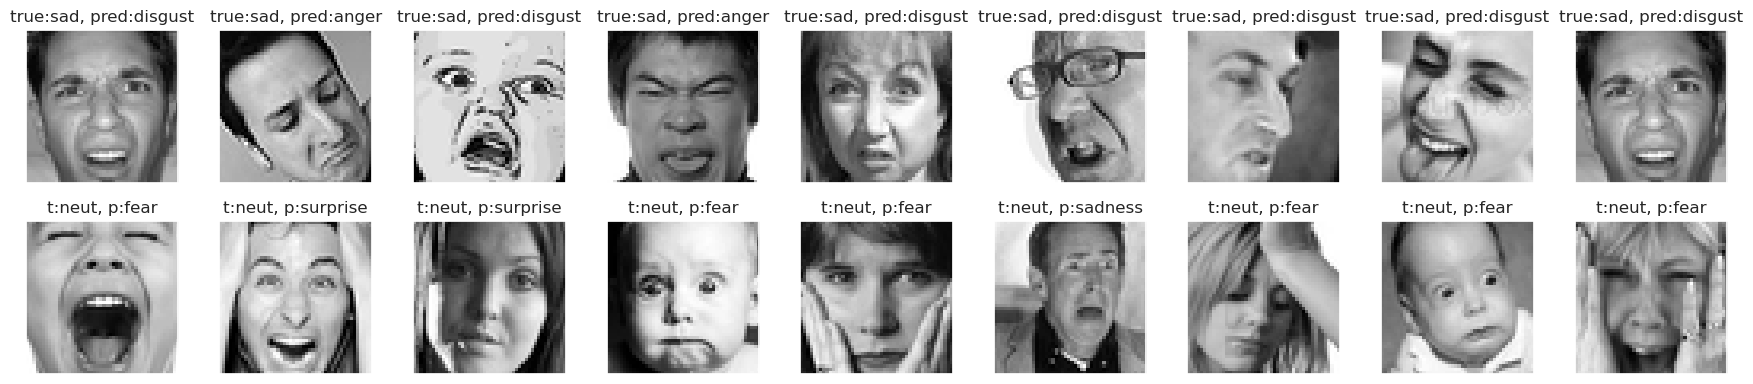

In [37]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()